In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 11 19:41:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
class MNISTGAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 64
    optimizer = Adam(0.0001, 0.5)
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                                optimizer=Adam(0.0002, 0.5),
                                metrics=['accuracy'])
    self.generator = self.build_generator()
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):
      model = Sequential()
      model.add(Dense(256, input_dim=self.latent_dim))
      model.add(LeakyReLU(alpha=0.2))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Dense(512))
      model.add(LeakyReLU(alpha=0.2))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Dense(1024))
      model.add(LeakyReLU(alpha=0.2))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Dense(np.prod(self.img_shape), activation='tanh'))
      model.add(Reshape(self.img_shape))
      noise = Input(shape=(self.latent_dim,))
      img = model(noise)
      model.summary()
      return Model(noise, img)

  def build_discriminator(self):
      model = Sequential()
      model.add(Flatten(input_shape=self.img_shape))
      model.add(Dense(512))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(256))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(1, activation='sigmoid'))
      img = Input(shape=self.img_shape)
      validity = model(img)
      model.summary()
      return Model(img, validity)

  def train(self, epochs, batch_size=128, sample_interval=1000):
      (X_train, _), (_, _) = mnist.load_data()
      X_train = X_train / 127.5 - 1.
      X_train = np.expand_dims(X_train, axis=3)
      valid = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))
      for epoch in range(epochs):
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
          g_loss = self.combined.train_on_batch(noise, valid)
          gen_imgs = self.generator.predict(noise)
          d_loss_real = self.discriminator.train_on_batch(imgs, valid)
          d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
          if epoch % sample_interval == 0:
            self.generate_numbers(epoch)
			
  def generate_numbers(self, epoch):
      noise = np.random.normal(0, 1, (1, gan.latent_dim))
      predictions = gan.generator.predict(noise)
      print(predictions.shape)
      print("Reshaping")
      generated_seq = np.reshape(predictions[0], (28,28))
      print(generated_seq.shape)
      plt.figure(figsize = (5,5))
      plt.imshow(generated_seq,aspect='auto',cmap='gray')
      #Path to be created in Google Drive to avoid failure
      plt.savefig("/content/drive/My Drive/DL/GAN/Results/GAN_MNIST/%d.png" % epoch)
      plt.show()
      plt.close()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.700015, acc.: 42.19%] [G loss: 0.649035]
(1, 28, 28, 1)
Reshaping
(28, 28)


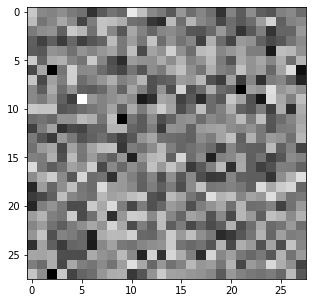

1 [D loss: 0.395593, acc.: 68.75%] [G loss: 0.630768]
2 [D loss: 0.379733, acc.: 64.06%] [G loss: 0.630520]
3 [D loss: 0.326234, acc.: 87.50%] [G loss: 0.690678]
4 [D loss: 0.285620, acc.: 98.44%] [G loss: 0.803991]
5 [D loss: 0.254530, acc.: 100.00%] [G loss: 0.873613]
6 [D loss: 0.205105, acc.: 100.00%] [G loss: 1.040834]
7 [D loss: 0.172176, acc.: 100.00%] [G loss: 1.172900]
8 [D loss: 0.131643, acc.: 100.00%] [G loss: 1.387056]
9 [D loss: 0.134504, acc.: 100.00%] [G loss: 1.452489]
10 [D loss: 0.102018, acc.: 100.00%] [G loss: 1.662090]
11 [D loss: 0.089764, acc.: 100.00%] [G loss: 1.797434]
12 [D loss: 0.089854, acc.: 100.00%] [G loss: 1.981414]
13 [D loss: 0.077370, acc.: 100.00%] [G loss: 2.061839]
14 [D loss: 0.071667, acc.: 100.00%] [G loss: 2.212717]
15 [D loss: 0.064363, acc.: 100.00%] [G loss: 2.443067]
16 [D loss: 0.061047, acc.: 100.00%] [G loss: 2.420413]
17 [D loss: 0.057726, acc.: 100.00%] [G loss: 2.557661]
18 [D loss: 0.048982, acc.: 100.00%] [G loss: 2.769240]
19 [D

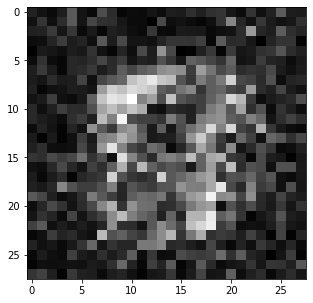

1001 [D loss: 0.558138, acc.: 82.81%] [G loss: 1.151455]
1002 [D loss: 0.610960, acc.: 67.19%] [G loss: 1.030732]
1003 [D loss: 0.569941, acc.: 65.62%] [G loss: 0.948583]
1004 [D loss: 0.572354, acc.: 65.62%] [G loss: 0.969662]
1005 [D loss: 0.632773, acc.: 64.06%] [G loss: 1.091086]
1006 [D loss: 0.585066, acc.: 68.75%] [G loss: 1.012615]
1007 [D loss: 0.596509, acc.: 67.19%] [G loss: 0.971296]
1008 [D loss: 0.530886, acc.: 75.00%] [G loss: 0.993065]
1009 [D loss: 0.578810, acc.: 67.19%] [G loss: 1.136334]
1010 [D loss: 0.599634, acc.: 71.88%] [G loss: 1.057431]
1011 [D loss: 0.546195, acc.: 70.31%] [G loss: 0.873578]
1012 [D loss: 0.550290, acc.: 71.88%] [G loss: 0.966018]
1013 [D loss: 0.555315, acc.: 82.81%] [G loss: 1.030618]
1014 [D loss: 0.618582, acc.: 65.62%] [G loss: 0.973051]
1015 [D loss: 0.569976, acc.: 76.56%] [G loss: 1.037242]
1016 [D loss: 0.564969, acc.: 71.88%] [G loss: 0.988537]
1017 [D loss: 0.562511, acc.: 76.56%] [G loss: 0.983716]
1018 [D loss: 0.552735, acc.: 7

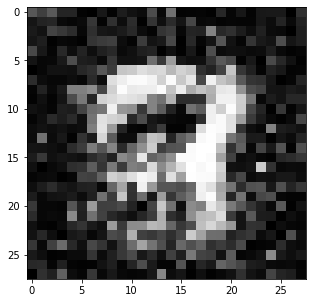

2001 [D loss: 0.504280, acc.: 76.56%] [G loss: 1.310206]
2002 [D loss: 0.504973, acc.: 81.25%] [G loss: 1.270558]
2003 [D loss: 0.542901, acc.: 71.88%] [G loss: 1.012470]
2004 [D loss: 0.442856, acc.: 84.38%] [G loss: 1.266346]
2005 [D loss: 0.508402, acc.: 78.12%] [G loss: 1.351638]
2006 [D loss: 0.554305, acc.: 68.75%] [G loss: 1.128423]
2007 [D loss: 0.531419, acc.: 75.00%] [G loss: 1.300966]
2008 [D loss: 0.530073, acc.: 75.00%] [G loss: 1.219028]
2009 [D loss: 0.576169, acc.: 65.62%] [G loss: 1.095930]
2010 [D loss: 0.494873, acc.: 81.25%] [G loss: 1.145604]
2011 [D loss: 0.511030, acc.: 76.56%] [G loss: 1.322950]
2012 [D loss: 0.506597, acc.: 79.69%] [G loss: 1.222425]
2013 [D loss: 0.547208, acc.: 75.00%] [G loss: 1.327792]
2014 [D loss: 0.459934, acc.: 84.38%] [G loss: 1.371423]
2015 [D loss: 0.508119, acc.: 76.56%] [G loss: 1.115191]
2016 [D loss: 0.479006, acc.: 84.38%] [G loss: 1.177522]
2017 [D loss: 0.495967, acc.: 73.44%] [G loss: 1.268610]
2018 [D loss: 0.462690, acc.: 8

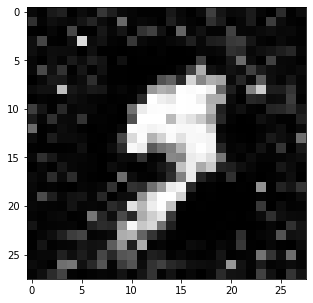

3001 [D loss: 0.575787, acc.: 65.62%] [G loss: 1.341132]
3002 [D loss: 0.474425, acc.: 76.56%] [G loss: 1.226291]
3003 [D loss: 0.461568, acc.: 84.38%] [G loss: 1.261451]
3004 [D loss: 0.523762, acc.: 79.69%] [G loss: 1.391452]
3005 [D loss: 0.560744, acc.: 68.75%] [G loss: 1.167487]
3006 [D loss: 0.423119, acc.: 85.94%] [G loss: 1.498729]
3007 [D loss: 0.509572, acc.: 78.12%] [G loss: 1.459847]
3008 [D loss: 0.455914, acc.: 82.81%] [G loss: 1.369680]
3009 [D loss: 0.585659, acc.: 71.88%] [G loss: 1.182202]
3010 [D loss: 0.433621, acc.: 82.81%] [G loss: 1.319768]
3011 [D loss: 0.558800, acc.: 70.31%] [G loss: 1.321988]
3012 [D loss: 0.536456, acc.: 71.88%] [G loss: 1.182259]
3013 [D loss: 0.437010, acc.: 82.81%] [G loss: 1.468167]
3014 [D loss: 0.543546, acc.: 71.88%] [G loss: 1.399264]
3015 [D loss: 0.509088, acc.: 82.81%] [G loss: 1.265121]
3016 [D loss: 0.525741, acc.: 76.56%] [G loss: 1.306322]
3017 [D loss: 0.559186, acc.: 70.31%] [G loss: 1.184407]
3018 [D loss: 0.369928, acc.: 8

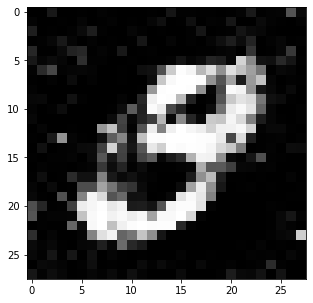

4001 [D loss: 0.565686, acc.: 75.00%] [G loss: 1.528566]
4002 [D loss: 0.544565, acc.: 76.56%] [G loss: 1.311739]
4003 [D loss: 0.618280, acc.: 71.88%] [G loss: 1.215087]
4004 [D loss: 0.526817, acc.: 75.00%] [G loss: 1.193822]
4005 [D loss: 0.531785, acc.: 73.44%] [G loss: 1.229106]
4006 [D loss: 0.475517, acc.: 75.00%] [G loss: 1.301390]
4007 [D loss: 0.576140, acc.: 71.88%] [G loss: 1.197273]
4008 [D loss: 0.542436, acc.: 73.44%] [G loss: 1.236926]
4009 [D loss: 0.497542, acc.: 81.25%] [G loss: 1.248795]
4010 [D loss: 0.479442, acc.: 76.56%] [G loss: 1.217095]
4011 [D loss: 0.572012, acc.: 73.44%] [G loss: 1.345744]
4012 [D loss: 0.476372, acc.: 79.69%] [G loss: 1.221160]
4013 [D loss: 0.629370, acc.: 62.50%] [G loss: 1.185239]
4014 [D loss: 0.571704, acc.: 67.19%] [G loss: 1.302299]
4015 [D loss: 0.531396, acc.: 75.00%] [G loss: 1.285868]
4016 [D loss: 0.481693, acc.: 79.69%] [G loss: 1.284773]
4017 [D loss: 0.525271, acc.: 70.31%] [G loss: 1.461769]
4018 [D loss: 0.566592, acc.: 6

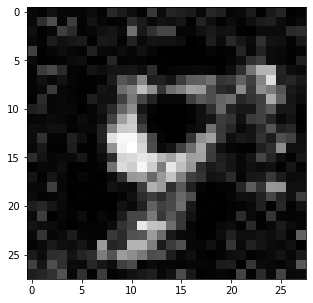

5001 [D loss: 0.543708, acc.: 71.88%] [G loss: 1.247272]
5002 [D loss: 0.498611, acc.: 75.00%] [G loss: 1.368295]
5003 [D loss: 0.643370, acc.: 64.06%] [G loss: 1.355814]
5004 [D loss: 0.551401, acc.: 75.00%] [G loss: 1.380749]
5005 [D loss: 0.486132, acc.: 84.38%] [G loss: 1.367983]
5006 [D loss: 0.445666, acc.: 81.25%] [G loss: 1.333261]
5007 [D loss: 0.559051, acc.: 70.31%] [G loss: 1.423974]
5008 [D loss: 0.532542, acc.: 73.44%] [G loss: 1.225804]
5009 [D loss: 0.548680, acc.: 68.75%] [G loss: 1.285704]
5010 [D loss: 0.472262, acc.: 81.25%] [G loss: 1.324078]
5011 [D loss: 0.547566, acc.: 75.00%] [G loss: 1.389930]
5012 [D loss: 0.556340, acc.: 71.88%] [G loss: 1.384217]
5013 [D loss: 0.570745, acc.: 75.00%] [G loss: 1.247471]
5014 [D loss: 0.585756, acc.: 67.19%] [G loss: 1.288260]
5015 [D loss: 0.578004, acc.: 71.88%] [G loss: 1.124050]
5016 [D loss: 0.596595, acc.: 65.62%] [G loss: 1.115440]
5017 [D loss: 0.539156, acc.: 70.31%] [G loss: 1.422002]
5018 [D loss: 0.500339, acc.: 7

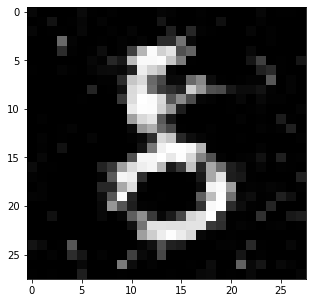

6001 [D loss: 0.426667, acc.: 78.12%] [G loss: 1.480523]
6002 [D loss: 0.579089, acc.: 73.44%] [G loss: 1.478675]
6003 [D loss: 0.592350, acc.: 65.62%] [G loss: 1.442776]
6004 [D loss: 0.477371, acc.: 78.12%] [G loss: 1.360276]
6005 [D loss: 0.484607, acc.: 73.44%] [G loss: 1.316273]
6006 [D loss: 0.543433, acc.: 75.00%] [G loss: 1.433916]
6007 [D loss: 0.503950, acc.: 75.00%] [G loss: 1.304029]
6008 [D loss: 0.588249, acc.: 64.06%] [G loss: 1.243276]
6009 [D loss: 0.636802, acc.: 62.50%] [G loss: 1.170918]
6010 [D loss: 0.629988, acc.: 67.19%] [G loss: 1.218828]
6011 [D loss: 0.519484, acc.: 75.00%] [G loss: 1.413819]
6012 [D loss: 0.608852, acc.: 62.50%] [G loss: 1.183977]
6013 [D loss: 0.511431, acc.: 73.44%] [G loss: 1.262173]
6014 [D loss: 0.570586, acc.: 70.31%] [G loss: 1.316345]
6015 [D loss: 0.505461, acc.: 76.56%] [G loss: 1.325379]
6016 [D loss: 0.480314, acc.: 79.69%] [G loss: 1.319437]
6017 [D loss: 0.474606, acc.: 76.56%] [G loss: 1.340752]
6018 [D loss: 0.506378, acc.: 8

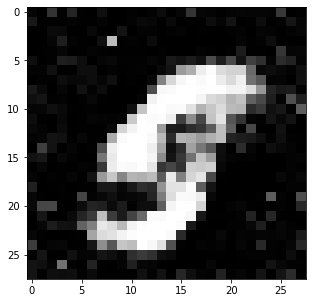

7001 [D loss: 0.557478, acc.: 75.00%] [G loss: 1.308424]
7002 [D loss: 0.616279, acc.: 67.19%] [G loss: 1.282383]
7003 [D loss: 0.558287, acc.: 76.56%] [G loss: 1.214822]
7004 [D loss: 0.515893, acc.: 79.69%] [G loss: 1.532531]
7005 [D loss: 0.567757, acc.: 70.31%] [G loss: 1.123339]
7006 [D loss: 0.565896, acc.: 73.44%] [G loss: 1.385149]
7007 [D loss: 0.475065, acc.: 82.81%] [G loss: 1.402359]
7008 [D loss: 0.547770, acc.: 71.88%] [G loss: 1.422810]
7009 [D loss: 0.520140, acc.: 76.56%] [G loss: 1.388415]
7010 [D loss: 0.619266, acc.: 68.75%] [G loss: 1.204597]
7011 [D loss: 0.526454, acc.: 70.31%] [G loss: 1.147946]
7012 [D loss: 0.588539, acc.: 65.62%] [G loss: 1.285203]
7013 [D loss: 0.596130, acc.: 71.88%] [G loss: 1.186451]
7014 [D loss: 0.503219, acc.: 76.56%] [G loss: 1.483038]
7015 [D loss: 0.613289, acc.: 70.31%] [G loss: 1.253768]
7016 [D loss: 0.542727, acc.: 68.75%] [G loss: 1.353575]
7017 [D loss: 0.572794, acc.: 65.62%] [G loss: 1.313563]
7018 [D loss: 0.523489, acc.: 7

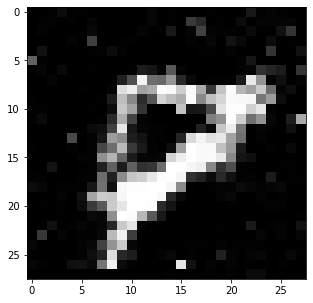

8001 [D loss: 0.590050, acc.: 73.44%] [G loss: 1.336144]
8002 [D loss: 0.592928, acc.: 68.75%] [G loss: 1.303173]
8003 [D loss: 0.571486, acc.: 68.75%] [G loss: 1.331583]
8004 [D loss: 0.539544, acc.: 65.62%] [G loss: 1.223456]
8005 [D loss: 0.607231, acc.: 59.38%] [G loss: 1.069843]
8006 [D loss: 0.525650, acc.: 76.56%] [G loss: 1.206502]
8007 [D loss: 0.613981, acc.: 68.75%] [G loss: 1.316642]
8008 [D loss: 0.654398, acc.: 62.50%] [G loss: 1.137647]
8009 [D loss: 0.644577, acc.: 68.75%] [G loss: 1.212168]
8010 [D loss: 0.589775, acc.: 68.75%] [G loss: 1.269760]
8011 [D loss: 0.540655, acc.: 73.44%] [G loss: 1.224368]
8012 [D loss: 0.632389, acc.: 71.88%] [G loss: 1.068673]
8013 [D loss: 0.621550, acc.: 70.31%] [G loss: 1.035301]
8014 [D loss: 0.585745, acc.: 76.56%] [G loss: 1.238829]
8015 [D loss: 0.568000, acc.: 71.88%] [G loss: 1.359984]
8016 [D loss: 0.535743, acc.: 70.31%] [G loss: 1.233186]
8017 [D loss: 0.523865, acc.: 81.25%] [G loss: 1.266825]
8018 [D loss: 0.622648, acc.: 6

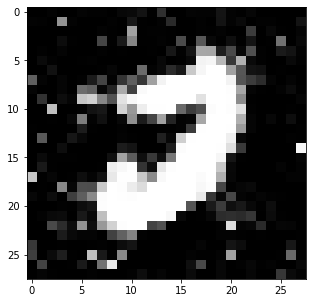

9001 [D loss: 0.765405, acc.: 57.81%] [G loss: 1.257257]
9002 [D loss: 0.645373, acc.: 59.38%] [G loss: 1.366430]
9003 [D loss: 0.688500, acc.: 57.81%] [G loss: 1.135083]
9004 [D loss: 0.521667, acc.: 73.44%] [G loss: 1.295868]
9005 [D loss: 0.577973, acc.: 70.31%] [G loss: 1.280246]
9006 [D loss: 0.519913, acc.: 76.56%] [G loss: 1.118451]
9007 [D loss: 0.576593, acc.: 65.62%] [G loss: 1.117081]
9008 [D loss: 0.624719, acc.: 70.31%] [G loss: 1.514726]
9009 [D loss: 0.595527, acc.: 65.62%] [G loss: 1.302153]
9010 [D loss: 0.599060, acc.: 75.00%] [G loss: 1.231139]
9011 [D loss: 0.752914, acc.: 53.12%] [G loss: 0.988538]
9012 [D loss: 0.548724, acc.: 75.00%] [G loss: 1.124477]
9013 [D loss: 0.571715, acc.: 67.19%] [G loss: 1.243500]
9014 [D loss: 0.622592, acc.: 64.06%] [G loss: 1.224242]
9015 [D loss: 0.534796, acc.: 73.44%] [G loss: 1.374659]
9016 [D loss: 0.697542, acc.: 59.38%] [G loss: 1.197364]
9017 [D loss: 0.552358, acc.: 68.75%] [G loss: 1.341324]
9018 [D loss: 0.585493, acc.: 6

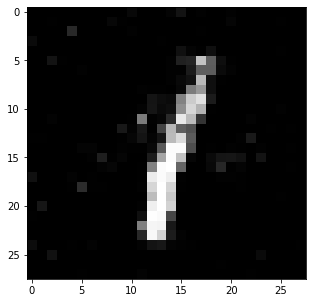

10001 [D loss: 0.567210, acc.: 71.88%] [G loss: 1.201622]
10002 [D loss: 0.608284, acc.: 62.50%] [G loss: 1.487375]
10003 [D loss: 0.618757, acc.: 64.06%] [G loss: 1.219098]
10004 [D loss: 0.510241, acc.: 76.56%] [G loss: 1.281361]
10005 [D loss: 0.607936, acc.: 65.62%] [G loss: 1.178173]
10006 [D loss: 0.566593, acc.: 70.31%] [G loss: 1.216155]
10007 [D loss: 0.616209, acc.: 62.50%] [G loss: 1.141419]
10008 [D loss: 0.487981, acc.: 76.56%] [G loss: 1.211714]
10009 [D loss: 0.639859, acc.: 68.75%] [G loss: 1.193798]
10010 [D loss: 0.525056, acc.: 78.12%] [G loss: 1.438522]
10011 [D loss: 0.598708, acc.: 73.44%] [G loss: 1.216841]
10012 [D loss: 0.618392, acc.: 62.50%] [G loss: 1.263821]
10013 [D loss: 0.635197, acc.: 64.06%] [G loss: 1.204158]
10014 [D loss: 0.544877, acc.: 70.31%] [G loss: 1.321206]
10015 [D loss: 0.564970, acc.: 70.31%] [G loss: 1.407642]
10016 [D loss: 0.546635, acc.: 76.56%] [G loss: 1.259128]
10017 [D loss: 0.613069, acc.: 60.94%] [G loss: 1.172571]
10018 [D loss:

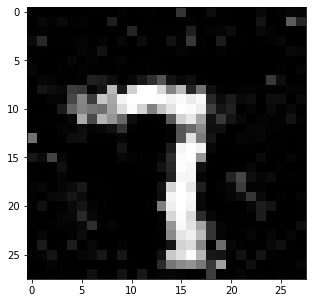

11001 [D loss: 0.503874, acc.: 79.69%] [G loss: 1.246052]
11002 [D loss: 0.533637, acc.: 78.12%] [G loss: 1.408528]
11003 [D loss: 0.642257, acc.: 62.50%] [G loss: 1.171987]
11004 [D loss: 0.634197, acc.: 65.62%] [G loss: 1.178659]
11005 [D loss: 0.540108, acc.: 76.56%] [G loss: 1.468467]
11006 [D loss: 0.618612, acc.: 56.25%] [G loss: 1.216500]
11007 [D loss: 0.534546, acc.: 76.56%] [G loss: 1.103757]
11008 [D loss: 0.543715, acc.: 73.44%] [G loss: 1.220336]
11009 [D loss: 0.595171, acc.: 68.75%] [G loss: 1.172850]
11010 [D loss: 0.607114, acc.: 64.06%] [G loss: 1.093985]
11011 [D loss: 0.602553, acc.: 68.75%] [G loss: 1.384158]
11012 [D loss: 0.630373, acc.: 64.06%] [G loss: 1.237756]
11013 [D loss: 0.500555, acc.: 78.12%] [G loss: 1.148908]
11014 [D loss: 0.612236, acc.: 73.44%] [G loss: 1.293271]
11015 [D loss: 0.496278, acc.: 75.00%] [G loss: 1.320682]
11016 [D loss: 0.580715, acc.: 70.31%] [G loss: 1.326025]
11017 [D loss: 0.655118, acc.: 64.06%] [G loss: 1.292645]
11018 [D loss:

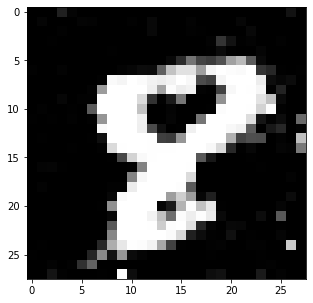

12001 [D loss: 0.525312, acc.: 67.19%] [G loss: 1.290624]
12002 [D loss: 0.548664, acc.: 78.12%] [G loss: 1.178250]
12003 [D loss: 0.550784, acc.: 75.00%] [G loss: 1.278178]
12004 [D loss: 0.652337, acc.: 57.81%] [G loss: 1.117903]
12005 [D loss: 0.617216, acc.: 67.19%] [G loss: 1.188197]
12006 [D loss: 0.577817, acc.: 65.62%] [G loss: 1.263844]
12007 [D loss: 0.562981, acc.: 70.31%] [G loss: 1.252423]
12008 [D loss: 0.621093, acc.: 62.50%] [G loss: 1.240809]
12009 [D loss: 0.568020, acc.: 76.56%] [G loss: 1.191118]
12010 [D loss: 0.625290, acc.: 64.06%] [G loss: 1.298590]
12011 [D loss: 0.553208, acc.: 79.69%] [G loss: 1.193388]
12012 [D loss: 0.621746, acc.: 64.06%] [G loss: 1.322765]
12013 [D loss: 0.600997, acc.: 59.38%] [G loss: 1.301136]
12014 [D loss: 0.617755, acc.: 71.88%] [G loss: 1.177434]
12015 [D loss: 0.652851, acc.: 59.38%] [G loss: 1.107232]
12016 [D loss: 0.554803, acc.: 70.31%] [G loss: 1.398935]
12017 [D loss: 0.651078, acc.: 60.94%] [G loss: 1.418062]
12018 [D loss:

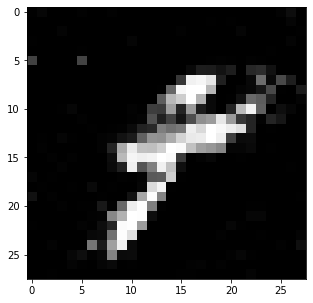

13001 [D loss: 0.623546, acc.: 67.19%] [G loss: 1.149974]
13002 [D loss: 0.654834, acc.: 68.75%] [G loss: 1.260822]
13003 [D loss: 0.549085, acc.: 73.44%] [G loss: 1.334275]
13004 [D loss: 0.602842, acc.: 67.19%] [G loss: 1.251639]
13005 [D loss: 0.543702, acc.: 68.75%] [G loss: 1.276973]
13006 [D loss: 0.560790, acc.: 71.88%] [G loss: 1.210217]
13007 [D loss: 0.533493, acc.: 73.44%] [G loss: 1.161454]
13008 [D loss: 0.610915, acc.: 62.50%] [G loss: 1.203337]
13009 [D loss: 0.691385, acc.: 59.38%] [G loss: 1.281368]
13010 [D loss: 0.533069, acc.: 71.88%] [G loss: 1.234930]
13011 [D loss: 0.607393, acc.: 65.62%] [G loss: 1.285853]
13012 [D loss: 0.524981, acc.: 76.56%] [G loss: 1.297216]
13013 [D loss: 0.590308, acc.: 62.50%] [G loss: 1.268227]
13014 [D loss: 0.572358, acc.: 75.00%] [G loss: 1.323633]
13015 [D loss: 0.657927, acc.: 65.62%] [G loss: 1.312226]
13016 [D loss: 0.569037, acc.: 68.75%] [G loss: 1.103265]
13017 [D loss: 0.674912, acc.: 56.25%] [G loss: 1.068232]
13018 [D loss:

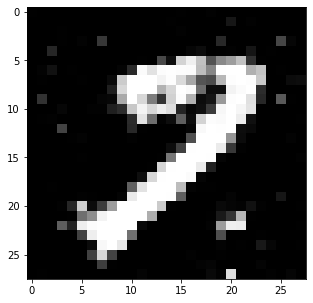

14001 [D loss: 0.629149, acc.: 65.62%] [G loss: 1.322674]
14002 [D loss: 0.679512, acc.: 60.94%] [G loss: 1.266601]
14003 [D loss: 0.541550, acc.: 70.31%] [G loss: 1.277610]
14004 [D loss: 0.605241, acc.: 68.75%] [G loss: 1.338445]
14005 [D loss: 0.599568, acc.: 65.62%] [G loss: 1.390414]
14006 [D loss: 0.714284, acc.: 56.25%] [G loss: 1.156712]
14007 [D loss: 0.634513, acc.: 64.06%] [G loss: 1.178063]
14008 [D loss: 0.676910, acc.: 56.25%] [G loss: 1.342853]
14009 [D loss: 0.558205, acc.: 68.75%] [G loss: 1.199346]
14010 [D loss: 0.644320, acc.: 65.62%] [G loss: 1.228187]
14011 [D loss: 0.549565, acc.: 73.44%] [G loss: 1.170798]
14012 [D loss: 0.643577, acc.: 60.94%] [G loss: 1.158015]
14013 [D loss: 0.537498, acc.: 71.88%] [G loss: 1.030364]
14014 [D loss: 0.680911, acc.: 57.81%] [G loss: 1.229525]
14015 [D loss: 0.634788, acc.: 67.19%] [G loss: 1.140298]
14016 [D loss: 0.659001, acc.: 54.69%] [G loss: 1.369857]
14017 [D loss: 0.486223, acc.: 78.12%] [G loss: 1.314353]
14018 [D loss:

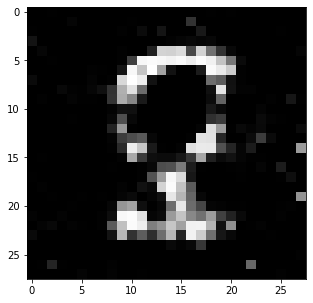

15001 [D loss: 0.654571, acc.: 54.69%] [G loss: 1.213866]
15002 [D loss: 0.570293, acc.: 60.94%] [G loss: 1.255953]
15003 [D loss: 0.625721, acc.: 67.19%] [G loss: 1.285477]
15004 [D loss: 0.678672, acc.: 59.38%] [G loss: 1.179017]
15005 [D loss: 0.566998, acc.: 71.88%] [G loss: 1.350943]
15006 [D loss: 0.564286, acc.: 65.62%] [G loss: 1.242728]
15007 [D loss: 0.611754, acc.: 68.75%] [G loss: 1.230372]
15008 [D loss: 0.549404, acc.: 73.44%] [G loss: 1.282073]
15009 [D loss: 0.537055, acc.: 73.44%] [G loss: 1.275678]
15010 [D loss: 0.513388, acc.: 79.69%] [G loss: 1.252981]
15011 [D loss: 0.504376, acc.: 71.88%] [G loss: 1.205184]
15012 [D loss: 0.617443, acc.: 64.06%] [G loss: 1.413052]
15013 [D loss: 0.582486, acc.: 70.31%] [G loss: 1.193945]
15014 [D loss: 0.525895, acc.: 73.44%] [G loss: 1.241640]
15015 [D loss: 0.549789, acc.: 70.31%] [G loss: 1.358184]
15016 [D loss: 0.633489, acc.: 67.19%] [G loss: 1.300951]
15017 [D loss: 0.698750, acc.: 65.62%] [G loss: 1.225002]
15018 [D loss:

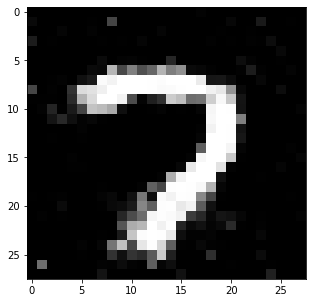

16001 [D loss: 0.547627, acc.: 71.88%] [G loss: 1.136498]
16002 [D loss: 0.541809, acc.: 75.00%] [G loss: 1.296057]
16003 [D loss: 0.560123, acc.: 71.88%] [G loss: 1.257537]
16004 [D loss: 0.574067, acc.: 67.19%] [G loss: 1.275984]
16005 [D loss: 0.623965, acc.: 67.19%] [G loss: 1.204367]
16006 [D loss: 0.566235, acc.: 68.75%] [G loss: 1.237669]
16007 [D loss: 0.634751, acc.: 68.75%] [G loss: 1.290788]
16008 [D loss: 0.545959, acc.: 76.56%] [G loss: 1.253467]
16009 [D loss: 0.575001, acc.: 68.75%] [G loss: 1.261355]
16010 [D loss: 0.558842, acc.: 76.56%] [G loss: 1.466072]
16011 [D loss: 0.582472, acc.: 68.75%] [G loss: 1.462023]
16012 [D loss: 0.645238, acc.: 53.12%] [G loss: 1.259417]
16013 [D loss: 0.603260, acc.: 62.50%] [G loss: 1.270134]
16014 [D loss: 0.570026, acc.: 71.88%] [G loss: 1.185321]
16015 [D loss: 0.583818, acc.: 73.44%] [G loss: 1.367854]
16016 [D loss: 0.642135, acc.: 60.94%] [G loss: 1.035225]
16017 [D loss: 0.580711, acc.: 71.88%] [G loss: 1.252850]
16018 [D loss:

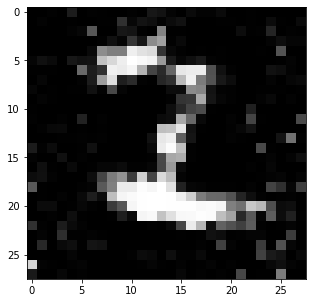

17001 [D loss: 0.591081, acc.: 68.75%] [G loss: 1.329377]
17002 [D loss: 0.560921, acc.: 73.44%] [G loss: 1.268460]
17003 [D loss: 0.567123, acc.: 70.31%] [G loss: 1.263081]
17004 [D loss: 0.600100, acc.: 59.38%] [G loss: 1.347107]
17005 [D loss: 0.618368, acc.: 64.06%] [G loss: 1.243880]
17006 [D loss: 0.545251, acc.: 73.44%] [G loss: 1.275865]
17007 [D loss: 0.679394, acc.: 57.81%] [G loss: 1.334237]
17008 [D loss: 0.593340, acc.: 65.62%] [G loss: 1.247557]
17009 [D loss: 0.642711, acc.: 59.38%] [G loss: 1.270805]
17010 [D loss: 0.656487, acc.: 64.06%] [G loss: 1.202271]
17011 [D loss: 0.565677, acc.: 71.88%] [G loss: 1.112771]
17012 [D loss: 0.570350, acc.: 75.00%] [G loss: 1.245745]
17013 [D loss: 0.536081, acc.: 75.00%] [G loss: 1.375914]
17014 [D loss: 0.627714, acc.: 57.81%] [G loss: 1.408772]
17015 [D loss: 0.609512, acc.: 64.06%] [G loss: 1.133232]
17016 [D loss: 0.558054, acc.: 71.88%] [G loss: 1.199235]
17017 [D loss: 0.664662, acc.: 62.50%] [G loss: 1.260203]
17018 [D loss:

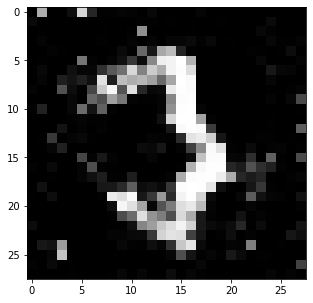

18001 [D loss: 0.690218, acc.: 59.38%] [G loss: 1.285922]
18002 [D loss: 0.550044, acc.: 71.88%] [G loss: 1.196930]
18003 [D loss: 0.577090, acc.: 65.62%] [G loss: 1.229979]
18004 [D loss: 0.521739, acc.: 73.44%] [G loss: 1.337704]
18005 [D loss: 0.600546, acc.: 67.19%] [G loss: 1.388807]
18006 [D loss: 0.563377, acc.: 73.44%] [G loss: 1.254720]
18007 [D loss: 0.617689, acc.: 59.38%] [G loss: 1.268819]
18008 [D loss: 0.597085, acc.: 73.44%] [G loss: 1.229966]
18009 [D loss: 0.692627, acc.: 50.00%] [G loss: 1.187521]
18010 [D loss: 0.600968, acc.: 67.19%] [G loss: 1.148516]
18011 [D loss: 0.604587, acc.: 62.50%] [G loss: 1.191351]
18012 [D loss: 0.707193, acc.: 56.25%] [G loss: 1.043130]
18013 [D loss: 0.553994, acc.: 68.75%] [G loss: 1.399026]
18014 [D loss: 0.539875, acc.: 73.44%] [G loss: 1.409488]
18015 [D loss: 0.600061, acc.: 54.69%] [G loss: 1.124969]
18016 [D loss: 0.581625, acc.: 65.62%] [G loss: 1.070463]
18017 [D loss: 0.549010, acc.: 68.75%] [G loss: 1.362015]
18018 [D loss:

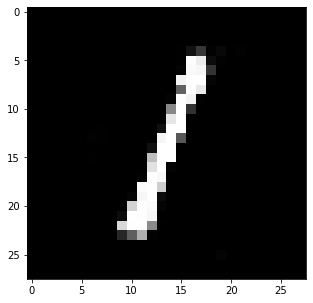

19001 [D loss: 0.553449, acc.: 75.00%] [G loss: 1.323155]
19002 [D loss: 0.626363, acc.: 68.75%] [G loss: 1.281796]
19003 [D loss: 0.648212, acc.: 59.38%] [G loss: 1.415098]
19004 [D loss: 0.660383, acc.: 57.81%] [G loss: 1.309349]
19005 [D loss: 0.633573, acc.: 62.50%] [G loss: 1.138282]
19006 [D loss: 0.576590, acc.: 68.75%] [G loss: 1.207145]
19007 [D loss: 0.563201, acc.: 76.56%] [G loss: 1.409505]
19008 [D loss: 0.667965, acc.: 51.56%] [G loss: 1.217108]
19009 [D loss: 0.561173, acc.: 68.75%] [G loss: 1.266891]
19010 [D loss: 0.627723, acc.: 71.88%] [G loss: 1.296690]
19011 [D loss: 0.674895, acc.: 64.06%] [G loss: 1.084206]
19012 [D loss: 0.596553, acc.: 68.75%] [G loss: 1.497264]
19013 [D loss: 0.607454, acc.: 67.19%] [G loss: 1.363417]
19014 [D loss: 0.542149, acc.: 73.44%] [G loss: 1.321338]
19015 [D loss: 0.604383, acc.: 62.50%] [G loss: 1.262071]
19016 [D loss: 0.572417, acc.: 67.19%] [G loss: 1.168071]
19017 [D loss: 0.620145, acc.: 59.38%] [G loss: 1.361959]
19018 [D loss:

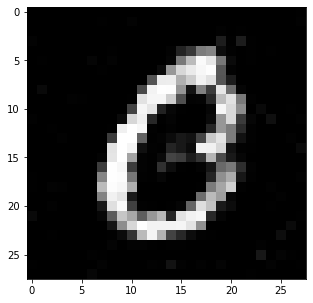

20001 [D loss: 0.631171, acc.: 68.75%] [G loss: 1.227730]
20002 [D loss: 0.679024, acc.: 54.69%] [G loss: 1.252827]
20003 [D loss: 0.566574, acc.: 70.31%] [G loss: 1.037412]
20004 [D loss: 0.593618, acc.: 67.19%] [G loss: 1.386111]
20005 [D loss: 0.653564, acc.: 62.50%] [G loss: 1.125908]
20006 [D loss: 0.501639, acc.: 78.12%] [G loss: 1.176167]
20007 [D loss: 0.597547, acc.: 67.19%] [G loss: 1.301635]
20008 [D loss: 0.596007, acc.: 62.50%] [G loss: 1.273964]
20009 [D loss: 0.627723, acc.: 65.62%] [G loss: 1.464344]
20010 [D loss: 0.569581, acc.: 70.31%] [G loss: 1.199624]
20011 [D loss: 0.594307, acc.: 71.88%] [G loss: 1.239620]
20012 [D loss: 0.598502, acc.: 65.62%] [G loss: 1.211769]
20013 [D loss: 0.565190, acc.: 65.62%] [G loss: 1.230339]
20014 [D loss: 0.620429, acc.: 67.19%] [G loss: 1.250485]
20015 [D loss: 0.595094, acc.: 71.88%] [G loss: 1.354491]
20016 [D loss: 0.599042, acc.: 70.31%] [G loss: 1.228105]
20017 [D loss: 0.646237, acc.: 68.75%] [G loss: 1.179579]
20018 [D loss:

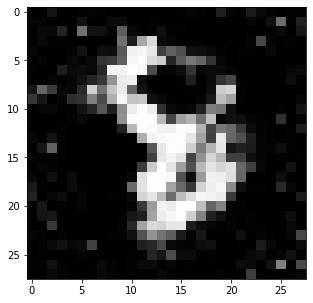

21001 [D loss: 0.535604, acc.: 65.62%] [G loss: 1.169138]
21002 [D loss: 0.587409, acc.: 65.62%] [G loss: 1.319015]
21003 [D loss: 0.553560, acc.: 75.00%] [G loss: 1.326997]
21004 [D loss: 0.663225, acc.: 68.75%] [G loss: 1.253085]
21005 [D loss: 0.564777, acc.: 68.75%] [G loss: 1.335278]
21006 [D loss: 0.567839, acc.: 67.19%] [G loss: 1.298804]
21007 [D loss: 0.542005, acc.: 75.00%] [G loss: 1.282199]
21008 [D loss: 0.576329, acc.: 70.31%] [G loss: 1.122364]
21009 [D loss: 0.602004, acc.: 64.06%] [G loss: 1.152986]
21010 [D loss: 0.476578, acc.: 79.69%] [G loss: 1.434317]
21011 [D loss: 0.489659, acc.: 75.00%] [G loss: 1.354787]
21012 [D loss: 0.574744, acc.: 76.56%] [G loss: 1.314987]
21013 [D loss: 0.633912, acc.: 67.19%] [G loss: 1.300563]
21014 [D loss: 0.631377, acc.: 62.50%] [G loss: 1.231550]
21015 [D loss: 0.620187, acc.: 59.38%] [G loss: 1.263609]
21016 [D loss: 0.660724, acc.: 60.94%] [G loss: 1.171053]
21017 [D loss: 0.598037, acc.: 70.31%] [G loss: 1.287081]
21018 [D loss:

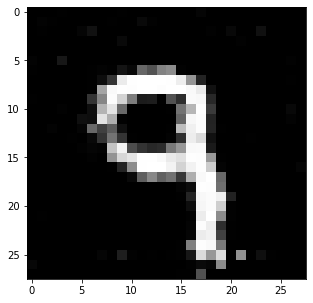

22001 [D loss: 0.583864, acc.: 68.75%] [G loss: 1.375146]
22002 [D loss: 0.650766, acc.: 60.94%] [G loss: 1.468739]
22003 [D loss: 0.657697, acc.: 65.62%] [G loss: 1.116583]
22004 [D loss: 0.625914, acc.: 60.94%] [G loss: 1.215561]
22005 [D loss: 0.527845, acc.: 75.00%] [G loss: 1.295807]
22006 [D loss: 0.556888, acc.: 67.19%] [G loss: 1.338904]
22007 [D loss: 0.615095, acc.: 71.88%] [G loss: 1.264353]
22008 [D loss: 0.674986, acc.: 62.50%] [G loss: 1.116565]
22009 [D loss: 0.437717, acc.: 81.25%] [G loss: 1.374466]
22010 [D loss: 0.616246, acc.: 65.62%] [G loss: 1.283169]
22011 [D loss: 0.647554, acc.: 59.38%] [G loss: 1.169461]
22012 [D loss: 0.502139, acc.: 73.44%] [G loss: 1.384540]
22013 [D loss: 0.633273, acc.: 68.75%] [G loss: 1.226081]
22014 [D loss: 0.554277, acc.: 76.56%] [G loss: 1.245673]
22015 [D loss: 0.521275, acc.: 79.69%] [G loss: 1.207839]
22016 [D loss: 0.707856, acc.: 56.25%] [G loss: 1.172036]
22017 [D loss: 0.556853, acc.: 76.56%] [G loss: 1.290421]
22018 [D loss:

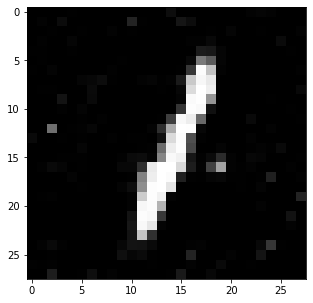

23001 [D loss: 0.610136, acc.: 64.06%] [G loss: 1.278668]
23002 [D loss: 0.649381, acc.: 68.75%] [G loss: 1.313996]
23003 [D loss: 0.614865, acc.: 68.75%] [G loss: 1.282802]
23004 [D loss: 0.617674, acc.: 67.19%] [G loss: 1.381333]
23005 [D loss: 0.571191, acc.: 71.88%] [G loss: 1.442565]
23006 [D loss: 0.591317, acc.: 73.44%] [G loss: 1.192759]
23007 [D loss: 0.585214, acc.: 73.44%] [G loss: 1.159831]
23008 [D loss: 0.567317, acc.: 68.75%] [G loss: 1.222996]
23009 [D loss: 0.665357, acc.: 64.06%] [G loss: 1.356806]
23010 [D loss: 0.656243, acc.: 54.69%] [G loss: 1.197316]
23011 [D loss: 0.561783, acc.: 76.56%] [G loss: 1.320647]
23012 [D loss: 0.601267, acc.: 64.06%] [G loss: 1.335482]
23013 [D loss: 0.640131, acc.: 56.25%] [G loss: 1.135634]
23014 [D loss: 0.482246, acc.: 76.56%] [G loss: 1.235527]
23015 [D loss: 0.553426, acc.: 75.00%] [G loss: 1.145788]
23016 [D loss: 0.680189, acc.: 60.94%] [G loss: 1.272148]
23017 [D loss: 0.551870, acc.: 73.44%] [G loss: 1.212173]
23018 [D loss:

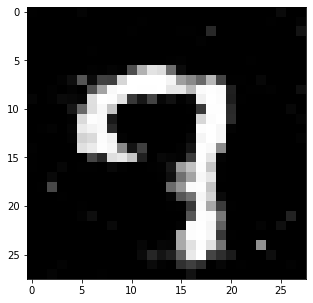

24001 [D loss: 0.619493, acc.: 70.31%] [G loss: 1.359087]
24002 [D loss: 0.566208, acc.: 68.75%] [G loss: 1.351181]
24003 [D loss: 0.563989, acc.: 67.19%] [G loss: 1.401807]
24004 [D loss: 0.593686, acc.: 67.19%] [G loss: 1.382109]
24005 [D loss: 0.632616, acc.: 64.06%] [G loss: 1.208152]
24006 [D loss: 0.613910, acc.: 65.62%] [G loss: 1.179442]
24007 [D loss: 0.593520, acc.: 60.94%] [G loss: 1.139563]
24008 [D loss: 0.666124, acc.: 62.50%] [G loss: 1.216311]
24009 [D loss: 0.570465, acc.: 70.31%] [G loss: 1.156955]
24010 [D loss: 0.704556, acc.: 53.12%] [G loss: 1.174942]
24011 [D loss: 0.680850, acc.: 56.25%] [G loss: 1.039266]
24012 [D loss: 0.575028, acc.: 67.19%] [G loss: 1.375634]
24013 [D loss: 0.505639, acc.: 67.19%] [G loss: 1.372734]
24014 [D loss: 0.493109, acc.: 82.81%] [G loss: 1.395836]
24015 [D loss: 0.643081, acc.: 64.06%] [G loss: 1.348836]
24016 [D loss: 0.610383, acc.: 67.19%] [G loss: 1.262978]
24017 [D loss: 0.491300, acc.: 76.56%] [G loss: 1.300310]
24018 [D loss:

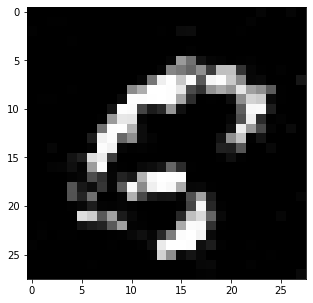

25001 [D loss: 0.550602, acc.: 73.44%] [G loss: 1.298095]
25002 [D loss: 0.566383, acc.: 73.44%] [G loss: 1.235417]
25003 [D loss: 0.626508, acc.: 65.62%] [G loss: 1.296316]
25004 [D loss: 0.562405, acc.: 76.56%] [G loss: 1.361338]
25005 [D loss: 0.584095, acc.: 60.94%] [G loss: 1.331279]
25006 [D loss: 0.634858, acc.: 57.81%] [G loss: 1.278073]
25007 [D loss: 0.620083, acc.: 60.94%] [G loss: 1.096499]
25008 [D loss: 0.655026, acc.: 64.06%] [G loss: 1.326146]
25009 [D loss: 0.652220, acc.: 68.75%] [G loss: 1.312191]
25010 [D loss: 0.547289, acc.: 75.00%] [G loss: 1.204602]
25011 [D loss: 0.534689, acc.: 76.56%] [G loss: 1.286199]
25012 [D loss: 0.550161, acc.: 75.00%] [G loss: 1.288915]
25013 [D loss: 0.533310, acc.: 76.56%] [G loss: 1.487315]
25014 [D loss: 0.515696, acc.: 76.56%] [G loss: 1.222310]
25015 [D loss: 0.620479, acc.: 68.75%] [G loss: 1.353541]
25016 [D loss: 0.603812, acc.: 65.62%] [G loss: 1.148624]
25017 [D loss: 0.547741, acc.: 65.62%] [G loss: 1.080613]
25018 [D loss:

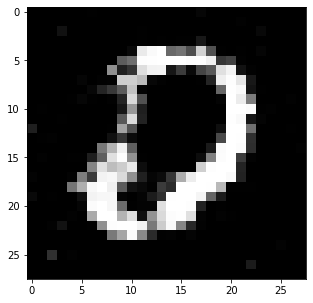

26001 [D loss: 0.701026, acc.: 57.81%] [G loss: 1.158406]
26002 [D loss: 0.602564, acc.: 60.94%] [G loss: 1.157465]
26003 [D loss: 0.558526, acc.: 67.19%] [G loss: 1.287028]
26004 [D loss: 0.600684, acc.: 60.94%] [G loss: 1.316808]
26005 [D loss: 0.518531, acc.: 76.56%] [G loss: 1.390004]
26006 [D loss: 0.598918, acc.: 68.75%] [G loss: 1.072938]
26007 [D loss: 0.498022, acc.: 76.56%] [G loss: 1.270642]
26008 [D loss: 0.777603, acc.: 54.69%] [G loss: 1.073914]
26009 [D loss: 0.513765, acc.: 76.56%] [G loss: 1.376352]
26010 [D loss: 0.783973, acc.: 51.56%] [G loss: 1.233259]
26011 [D loss: 0.543448, acc.: 73.44%] [G loss: 1.215611]
26012 [D loss: 0.623808, acc.: 64.06%] [G loss: 1.232121]
26013 [D loss: 0.566543, acc.: 65.62%] [G loss: 1.468261]
26014 [D loss: 0.684100, acc.: 62.50%] [G loss: 1.024537]
26015 [D loss: 0.552281, acc.: 71.88%] [G loss: 1.292450]
26016 [D loss: 0.582376, acc.: 67.19%] [G loss: 1.345699]
26017 [D loss: 0.707175, acc.: 53.12%] [G loss: 1.225948]
26018 [D loss:

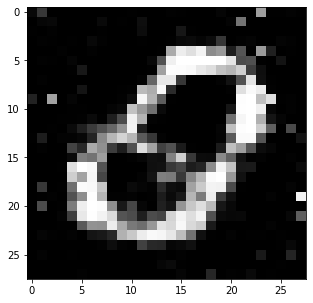

27001 [D loss: 0.581523, acc.: 65.62%] [G loss: 1.252581]
27002 [D loss: 0.588430, acc.: 68.75%] [G loss: 1.203478]
27003 [D loss: 0.554288, acc.: 78.12%] [G loss: 1.271132]
27004 [D loss: 0.621157, acc.: 64.06%] [G loss: 1.112998]
27005 [D loss: 0.592442, acc.: 70.31%] [G loss: 1.270001]
27006 [D loss: 0.564859, acc.: 73.44%] [G loss: 1.292076]
27007 [D loss: 0.641633, acc.: 59.38%] [G loss: 1.269530]
27008 [D loss: 0.656341, acc.: 59.38%] [G loss: 1.118628]
27009 [D loss: 0.554841, acc.: 67.19%] [G loss: 1.235426]
27010 [D loss: 0.621321, acc.: 65.62%] [G loss: 1.000063]
27011 [D loss: 0.597009, acc.: 68.75%] [G loss: 1.333873]
27012 [D loss: 0.627125, acc.: 65.62%] [G loss: 1.053003]
27013 [D loss: 0.558890, acc.: 67.19%] [G loss: 1.262741]
27014 [D loss: 0.573665, acc.: 67.19%] [G loss: 1.325038]
27015 [D loss: 0.563282, acc.: 71.88%] [G loss: 1.381331]
27016 [D loss: 0.577486, acc.: 67.19%] [G loss: 1.198829]
27017 [D loss: 0.591937, acc.: 68.75%] [G loss: 1.244365]
27018 [D loss:

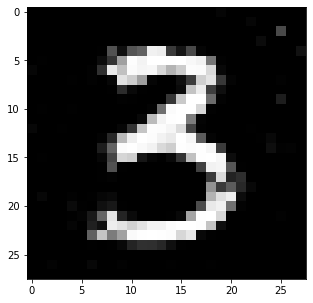

28001 [D loss: 0.509993, acc.: 78.12%] [G loss: 1.431932]
28002 [D loss: 0.564806, acc.: 75.00%] [G loss: 1.627027]
28003 [D loss: 0.611019, acc.: 67.19%] [G loss: 1.165818]
28004 [D loss: 0.637259, acc.: 62.50%] [G loss: 1.017827]
28005 [D loss: 0.553049, acc.: 68.75%] [G loss: 1.204453]
28006 [D loss: 0.625286, acc.: 60.94%] [G loss: 1.333014]
28007 [D loss: 0.602425, acc.: 68.75%] [G loss: 1.188053]
28008 [D loss: 0.492178, acc.: 79.69%] [G loss: 1.305270]
28009 [D loss: 0.652156, acc.: 64.06%] [G loss: 1.243479]
28010 [D loss: 0.530009, acc.: 70.31%] [G loss: 1.277539]
28011 [D loss: 0.549527, acc.: 70.31%] [G loss: 1.417304]
28012 [D loss: 0.590058, acc.: 65.62%] [G loss: 1.394683]
28013 [D loss: 0.619569, acc.: 64.06%] [G loss: 1.275528]
28014 [D loss: 0.581665, acc.: 60.94%] [G loss: 1.308015]
28015 [D loss: 0.617543, acc.: 70.31%] [G loss: 1.214123]
28016 [D loss: 0.571856, acc.: 73.44%] [G loss: 1.112844]
28017 [D loss: 0.587160, acc.: 64.06%] [G loss: 1.138121]
28018 [D loss:

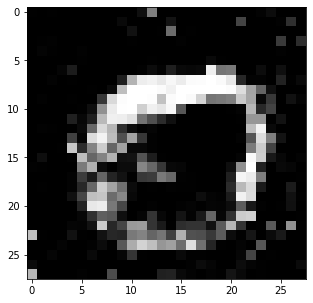

29001 [D loss: 0.705008, acc.: 56.25%] [G loss: 1.137368]
29002 [D loss: 0.636767, acc.: 62.50%] [G loss: 1.477974]
29003 [D loss: 0.539320, acc.: 73.44%] [G loss: 1.220605]
29004 [D loss: 0.691894, acc.: 60.94%] [G loss: 1.316659]
29005 [D loss: 0.638887, acc.: 56.25%] [G loss: 1.090228]
29006 [D loss: 0.517908, acc.: 73.44%] [G loss: 1.125815]
29007 [D loss: 0.565597, acc.: 71.88%] [G loss: 1.407882]
29008 [D loss: 0.540697, acc.: 70.31%] [G loss: 1.164854]
29009 [D loss: 0.629707, acc.: 59.38%] [G loss: 1.132207]
29010 [D loss: 0.637903, acc.: 70.31%] [G loss: 1.325444]
29011 [D loss: 0.668513, acc.: 57.81%] [G loss: 1.214593]
29012 [D loss: 0.634133, acc.: 64.06%] [G loss: 1.207259]
29013 [D loss: 0.651027, acc.: 59.38%] [G loss: 1.212722]
29014 [D loss: 0.600293, acc.: 68.75%] [G loss: 1.093467]
29015 [D loss: 0.579639, acc.: 65.62%] [G loss: 1.132097]
29016 [D loss: 0.633516, acc.: 70.31%] [G loss: 1.107951]
29017 [D loss: 0.599540, acc.: 70.31%] [G loss: 1.282509]
29018 [D loss:

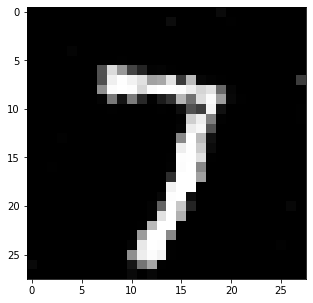

30001 [D loss: 0.604178, acc.: 67.19%] [G loss: 1.298781]
30002 [D loss: 0.627071, acc.: 65.62%] [G loss: 1.369057]
30003 [D loss: 0.576136, acc.: 70.31%] [G loss: 1.327532]
30004 [D loss: 0.623386, acc.: 62.50%] [G loss: 1.352637]
30005 [D loss: 0.607155, acc.: 65.62%] [G loss: 1.204937]
30006 [D loss: 0.580633, acc.: 71.88%] [G loss: 1.335938]
30007 [D loss: 0.577801, acc.: 64.06%] [G loss: 1.331589]
30008 [D loss: 0.636685, acc.: 65.62%] [G loss: 1.223512]
30009 [D loss: 0.562291, acc.: 75.00%] [G loss: 1.202713]
30010 [D loss: 0.660628, acc.: 67.19%] [G loss: 1.074811]
30011 [D loss: 0.572373, acc.: 64.06%] [G loss: 1.399098]
30012 [D loss: 0.619395, acc.: 67.19%] [G loss: 1.200141]
30013 [D loss: 0.642897, acc.: 62.50%] [G loss: 1.270799]
30014 [D loss: 0.631484, acc.: 62.50%] [G loss: 1.287311]
30015 [D loss: 0.627999, acc.: 65.62%] [G loss: 1.061731]
30016 [D loss: 0.643069, acc.: 64.06%] [G loss: 1.298341]
30017 [D loss: 0.566410, acc.: 70.31%] [G loss: 1.356287]
30018 [D loss:

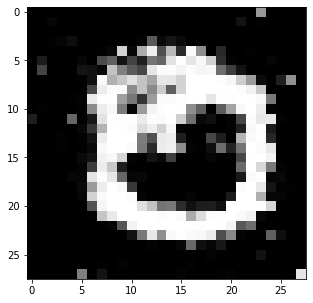

31001 [D loss: 0.517599, acc.: 70.31%] [G loss: 1.408553]
31002 [D loss: 0.637124, acc.: 65.62%] [G loss: 1.512599]
31003 [D loss: 0.666083, acc.: 57.81%] [G loss: 1.083288]
31004 [D loss: 0.601830, acc.: 59.38%] [G loss: 1.186235]
31005 [D loss: 0.609354, acc.: 62.50%] [G loss: 1.290482]
31006 [D loss: 0.537038, acc.: 75.00%] [G loss: 1.330475]
31007 [D loss: 0.579244, acc.: 73.44%] [G loss: 1.311186]
31008 [D loss: 0.659595, acc.: 64.06%] [G loss: 1.170725]
31009 [D loss: 0.651618, acc.: 64.06%] [G loss: 1.243762]
31010 [D loss: 0.582872, acc.: 67.19%] [G loss: 1.118017]
31011 [D loss: 0.616882, acc.: 65.62%] [G loss: 1.311886]
31012 [D loss: 0.607888, acc.: 68.75%] [G loss: 1.393944]
31013 [D loss: 0.596102, acc.: 60.94%] [G loss: 1.236732]
31014 [D loss: 0.581969, acc.: 70.31%] [G loss: 1.228907]
31015 [D loss: 0.636990, acc.: 59.38%] [G loss: 1.118111]
31016 [D loss: 0.514916, acc.: 71.88%] [G loss: 1.230457]
31017 [D loss: 0.592492, acc.: 67.19%] [G loss: 1.354476]
31018 [D loss:

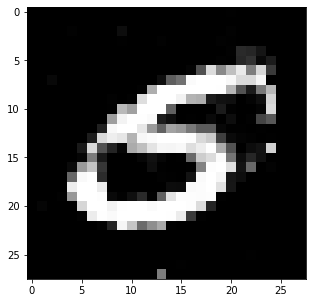

32001 [D loss: 0.728474, acc.: 51.56%] [G loss: 1.079868]
32002 [D loss: 0.549734, acc.: 68.75%] [G loss: 1.261417]
32003 [D loss: 0.641475, acc.: 57.81%] [G loss: 1.195454]
32004 [D loss: 0.721226, acc.: 56.25%] [G loss: 1.112833]
32005 [D loss: 0.545577, acc.: 73.44%] [G loss: 1.552455]
32006 [D loss: 0.632995, acc.: 62.50%] [G loss: 1.275067]
32007 [D loss: 0.653838, acc.: 60.94%] [G loss: 1.096780]
32008 [D loss: 0.563998, acc.: 73.44%] [G loss: 1.214605]
32009 [D loss: 0.513536, acc.: 76.56%] [G loss: 1.317821]
32010 [D loss: 0.645723, acc.: 56.25%] [G loss: 1.059269]
32011 [D loss: 0.515468, acc.: 76.56%] [G loss: 1.282352]
32012 [D loss: 0.660193, acc.: 60.94%] [G loss: 1.142556]
32013 [D loss: 0.620164, acc.: 62.50%] [G loss: 1.107088]
32014 [D loss: 0.602927, acc.: 62.50%] [G loss: 1.259905]
32015 [D loss: 0.594937, acc.: 67.19%] [G loss: 1.311074]
32016 [D loss: 0.626491, acc.: 62.50%] [G loss: 1.289900]
32017 [D loss: 0.584474, acc.: 68.75%] [G loss: 1.243492]
32018 [D loss:

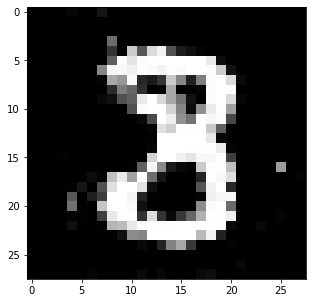

33001 [D loss: 0.612037, acc.: 70.31%] [G loss: 1.297404]
33002 [D loss: 0.651933, acc.: 60.94%] [G loss: 1.398223]
33003 [D loss: 0.538138, acc.: 75.00%] [G loss: 1.245887]
33004 [D loss: 0.666411, acc.: 62.50%] [G loss: 1.034666]
33005 [D loss: 0.584044, acc.: 70.31%] [G loss: 1.227762]
33006 [D loss: 0.775873, acc.: 50.00%] [G loss: 1.071682]
33007 [D loss: 0.593127, acc.: 60.94%] [G loss: 1.107485]
33008 [D loss: 0.647807, acc.: 62.50%] [G loss: 1.328372]
33009 [D loss: 0.545126, acc.: 71.88%] [G loss: 1.274173]
33010 [D loss: 0.598263, acc.: 65.62%] [G loss: 1.382459]
33011 [D loss: 0.604433, acc.: 60.94%] [G loss: 1.274308]
33012 [D loss: 0.571897, acc.: 65.62%] [G loss: 1.372088]
33013 [D loss: 0.686405, acc.: 70.31%] [G loss: 1.236844]
33014 [D loss: 0.603842, acc.: 67.19%] [G loss: 1.183817]
33015 [D loss: 0.550299, acc.: 71.88%] [G loss: 1.480756]
33016 [D loss: 0.603910, acc.: 60.94%] [G loss: 1.286337]
33017 [D loss: 0.605393, acc.: 68.75%] [G loss: 1.170814]
33018 [D loss:

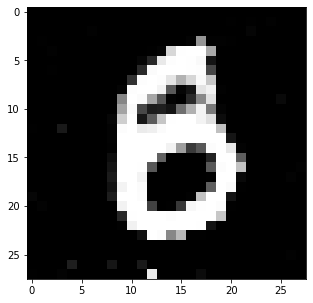

34001 [D loss: 0.589707, acc.: 68.75%] [G loss: 1.257480]
34002 [D loss: 0.720880, acc.: 53.12%] [G loss: 1.195689]
34003 [D loss: 0.733503, acc.: 54.69%] [G loss: 1.038541]
34004 [D loss: 0.530119, acc.: 73.44%] [G loss: 1.329839]
34005 [D loss: 0.691673, acc.: 53.12%] [G loss: 1.226083]
34006 [D loss: 0.607679, acc.: 68.75%] [G loss: 1.312025]
34007 [D loss: 0.560274, acc.: 71.88%] [G loss: 1.290423]
34008 [D loss: 0.558334, acc.: 67.19%] [G loss: 1.373284]
34009 [D loss: 0.628039, acc.: 67.19%] [G loss: 1.300831]
34010 [D loss: 0.656578, acc.: 64.06%] [G loss: 1.195277]
34011 [D loss: 0.561723, acc.: 71.88%] [G loss: 1.216370]
34012 [D loss: 0.629848, acc.: 64.06%] [G loss: 1.288373]
34013 [D loss: 0.683665, acc.: 56.25%] [G loss: 1.001291]
34014 [D loss: 0.709312, acc.: 54.69%] [G loss: 1.088249]
34015 [D loss: 0.497504, acc.: 84.38%] [G loss: 1.325197]
34016 [D loss: 0.538304, acc.: 70.31%] [G loss: 1.228635]
34017 [D loss: 0.620945, acc.: 67.19%] [G loss: 1.326409]
34018 [D loss:

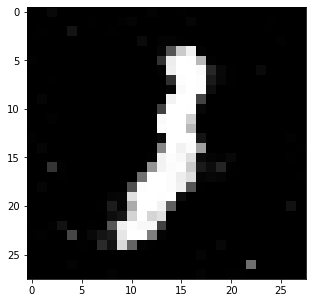

35001 [D loss: 0.616188, acc.: 67.19%] [G loss: 1.166394]
35002 [D loss: 0.591816, acc.: 57.81%] [G loss: 1.398488]
35003 [D loss: 0.689847, acc.: 57.81%] [G loss: 1.166511]
35004 [D loss: 0.695184, acc.: 59.38%] [G loss: 1.142112]
35005 [D loss: 0.569084, acc.: 71.88%] [G loss: 1.455964]
35006 [D loss: 0.604189, acc.: 62.50%] [G loss: 1.080579]
35007 [D loss: 0.599993, acc.: 71.88%] [G loss: 1.339109]
35008 [D loss: 0.595309, acc.: 67.19%] [G loss: 1.159776]
35009 [D loss: 0.553840, acc.: 75.00%] [G loss: 1.241366]
35010 [D loss: 0.648646, acc.: 64.06%] [G loss: 1.375576]
35011 [D loss: 0.666687, acc.: 56.25%] [G loss: 1.218563]
35012 [D loss: 0.590026, acc.: 68.75%] [G loss: 1.280302]
35013 [D loss: 0.569908, acc.: 70.31%] [G loss: 1.501302]
35014 [D loss: 0.589679, acc.: 73.44%] [G loss: 1.217418]
35015 [D loss: 0.632509, acc.: 64.06%] [G loss: 1.227293]
35016 [D loss: 0.663661, acc.: 54.69%] [G loss: 1.190773]
35017 [D loss: 0.726554, acc.: 54.69%] [G loss: 1.191256]
35018 [D loss:

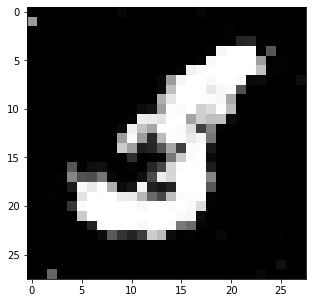

36001 [D loss: 0.645835, acc.: 65.62%] [G loss: 1.310117]
36002 [D loss: 0.666778, acc.: 59.38%] [G loss: 1.274690]
36003 [D loss: 0.582066, acc.: 67.19%] [G loss: 1.569520]
36004 [D loss: 0.646245, acc.: 62.50%] [G loss: 1.144950]
36005 [D loss: 0.567753, acc.: 68.75%] [G loss: 1.300843]
36006 [D loss: 0.651363, acc.: 54.69%] [G loss: 1.065083]
36007 [D loss: 0.596216, acc.: 65.62%] [G loss: 1.254198]
36008 [D loss: 0.607809, acc.: 62.50%] [G loss: 1.232092]
36009 [D loss: 0.613617, acc.: 64.06%] [G loss: 1.243368]
36010 [D loss: 0.637337, acc.: 62.50%] [G loss: 1.344198]
36011 [D loss: 0.732821, acc.: 50.00%] [G loss: 1.169531]
36012 [D loss: 0.608717, acc.: 67.19%] [G loss: 1.194823]
36013 [D loss: 0.713483, acc.: 56.25%] [G loss: 1.139805]
36014 [D loss: 0.623211, acc.: 59.38%] [G loss: 1.279521]
36015 [D loss: 0.694891, acc.: 56.25%] [G loss: 1.215365]
36016 [D loss: 0.606237, acc.: 59.38%] [G loss: 1.165458]
36017 [D loss: 0.492651, acc.: 76.56%] [G loss: 1.354363]
36018 [D loss:

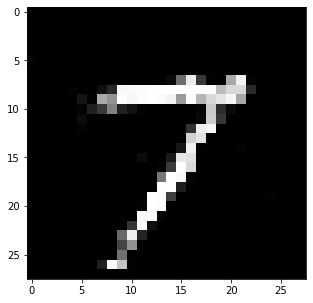

37001 [D loss: 0.617681, acc.: 60.94%] [G loss: 1.284485]
37002 [D loss: 0.567758, acc.: 71.88%] [G loss: 1.116832]
37003 [D loss: 0.667918, acc.: 56.25%] [G loss: 1.265467]
37004 [D loss: 0.627501, acc.: 59.38%] [G loss: 1.173208]
37005 [D loss: 0.621084, acc.: 73.44%] [G loss: 1.112686]
37006 [D loss: 0.495872, acc.: 73.44%] [G loss: 1.307978]
37007 [D loss: 0.587842, acc.: 71.88%] [G loss: 1.314017]
37008 [D loss: 0.686829, acc.: 62.50%] [G loss: 1.294217]
37009 [D loss: 0.707534, acc.: 56.25%] [G loss: 1.385108]
37010 [D loss: 0.607421, acc.: 73.44%] [G loss: 1.202870]
37011 [D loss: 0.669942, acc.: 60.94%] [G loss: 1.113579]
37012 [D loss: 0.639476, acc.: 60.94%] [G loss: 1.251988]
37013 [D loss: 0.633026, acc.: 62.50%] [G loss: 1.222778]
37014 [D loss: 0.509298, acc.: 75.00%] [G loss: 1.339592]
37015 [D loss: 0.610475, acc.: 67.19%] [G loss: 1.245309]
37016 [D loss: 0.497640, acc.: 82.81%] [G loss: 1.299381]
37017 [D loss: 0.573489, acc.: 67.19%] [G loss: 1.082083]
37018 [D loss:

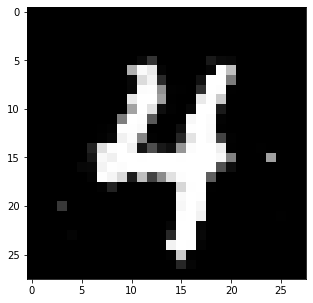

38001 [D loss: 0.570669, acc.: 64.06%] [G loss: 1.117777]
38002 [D loss: 0.611518, acc.: 71.88%] [G loss: 1.337312]
38003 [D loss: 0.675346, acc.: 67.19%] [G loss: 1.367757]
38004 [D loss: 0.614412, acc.: 68.75%] [G loss: 1.128942]
38005 [D loss: 0.706717, acc.: 48.44%] [G loss: 1.183510]
38006 [D loss: 0.644500, acc.: 57.81%] [G loss: 1.067097]
38007 [D loss: 0.600152, acc.: 68.75%] [G loss: 1.274492]
38008 [D loss: 0.626354, acc.: 65.62%] [G loss: 1.298037]
38009 [D loss: 0.621413, acc.: 64.06%] [G loss: 1.084010]
38010 [D loss: 0.574464, acc.: 71.88%] [G loss: 1.163650]
38011 [D loss: 0.522149, acc.: 68.75%] [G loss: 1.257321]
38012 [D loss: 0.638826, acc.: 64.06%] [G loss: 1.292071]
38013 [D loss: 0.581079, acc.: 67.19%] [G loss: 1.161160]
38014 [D loss: 0.685833, acc.: 57.81%] [G loss: 1.288789]
38015 [D loss: 0.585441, acc.: 70.31%] [G loss: 1.176090]
38016 [D loss: 0.601190, acc.: 64.06%] [G loss: 1.330364]
38017 [D loss: 0.621222, acc.: 67.19%] [G loss: 1.094220]
38018 [D loss:

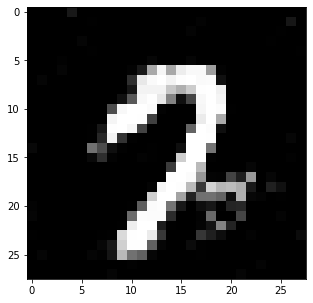

39001 [D loss: 0.542768, acc.: 71.88%] [G loss: 1.346521]
39002 [D loss: 0.491998, acc.: 81.25%] [G loss: 1.414067]
39003 [D loss: 0.642263, acc.: 62.50%] [G loss: 1.326129]
39004 [D loss: 0.614114, acc.: 68.75%] [G loss: 1.236413]
39005 [D loss: 0.631572, acc.: 62.50%] [G loss: 1.280890]
39006 [D loss: 0.543234, acc.: 73.44%] [G loss: 1.418984]
39007 [D loss: 0.606636, acc.: 70.31%] [G loss: 1.209567]
39008 [D loss: 0.670402, acc.: 59.38%] [G loss: 1.242609]
39009 [D loss: 0.669562, acc.: 53.12%] [G loss: 1.224796]
39010 [D loss: 0.608451, acc.: 62.50%] [G loss: 1.183082]
39011 [D loss: 0.648118, acc.: 60.94%] [G loss: 1.049878]
39012 [D loss: 0.597803, acc.: 67.19%] [G loss: 1.192896]
39013 [D loss: 0.518576, acc.: 73.44%] [G loss: 1.372714]
39014 [D loss: 0.556510, acc.: 73.44%] [G loss: 1.350934]
39015 [D loss: 0.622449, acc.: 67.19%] [G loss: 1.174137]
39016 [D loss: 0.675643, acc.: 59.38%] [G loss: 1.287112]
39017 [D loss: 0.628524, acc.: 62.50%] [G loss: 1.392434]
39018 [D loss:

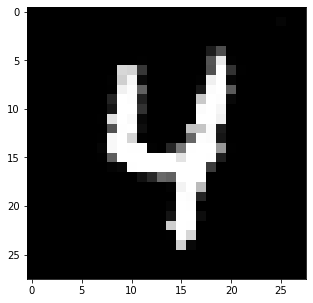

40001 [D loss: 0.601292, acc.: 59.38%] [G loss: 1.098369]
40002 [D loss: 0.595534, acc.: 70.31%] [G loss: 1.231824]
40003 [D loss: 0.665738, acc.: 59.38%] [G loss: 1.295938]
40004 [D loss: 0.602849, acc.: 70.31%] [G loss: 1.304629]
40005 [D loss: 0.628310, acc.: 65.62%] [G loss: 1.304861]
40006 [D loss: 0.615701, acc.: 60.94%] [G loss: 1.282815]
40007 [D loss: 0.584079, acc.: 68.75%] [G loss: 1.312763]
40008 [D loss: 0.565067, acc.: 71.88%] [G loss: 1.272408]
40009 [D loss: 0.668139, acc.: 59.38%] [G loss: 1.063290]
40010 [D loss: 0.621641, acc.: 68.75%] [G loss: 1.123913]
40011 [D loss: 0.589830, acc.: 67.19%] [G loss: 1.355842]
40012 [D loss: 0.613351, acc.: 59.38%] [G loss: 1.533971]
40013 [D loss: 0.586173, acc.: 68.75%] [G loss: 1.366587]
40014 [D loss: 0.637327, acc.: 59.38%] [G loss: 1.114472]
40015 [D loss: 0.560615, acc.: 70.31%] [G loss: 1.120538]
40016 [D loss: 0.640243, acc.: 64.06%] [G loss: 1.230312]
40017 [D loss: 0.593744, acc.: 67.19%] [G loss: 1.229975]
40018 [D loss:

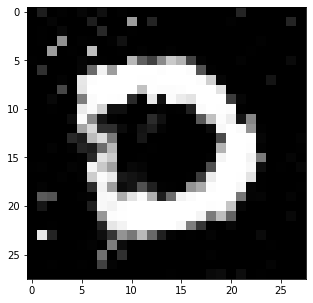

41001 [D loss: 0.627125, acc.: 65.62%] [G loss: 1.209466]
41002 [D loss: 0.618892, acc.: 65.62%] [G loss: 1.212395]
41003 [D loss: 0.586725, acc.: 67.19%] [G loss: 1.228153]
41004 [D loss: 0.685006, acc.: 57.81%] [G loss: 1.308084]
41005 [D loss: 0.591835, acc.: 68.75%] [G loss: 1.334600]
41006 [D loss: 0.566267, acc.: 75.00%] [G loss: 1.259413]
41007 [D loss: 0.560065, acc.: 75.00%] [G loss: 1.232338]
41008 [D loss: 0.663791, acc.: 59.38%] [G loss: 1.157845]
41009 [D loss: 0.593319, acc.: 68.75%] [G loss: 1.213533]
41010 [D loss: 0.646967, acc.: 68.75%] [G loss: 1.158512]
41011 [D loss: 0.611101, acc.: 68.75%] [G loss: 1.435852]
41012 [D loss: 0.653882, acc.: 59.38%] [G loss: 1.298014]
41013 [D loss: 0.500364, acc.: 76.56%] [G loss: 1.380852]
41014 [D loss: 0.628865, acc.: 62.50%] [G loss: 1.326957]
41015 [D loss: 0.653031, acc.: 65.62%] [G loss: 1.229222]
41016 [D loss: 0.602130, acc.: 59.38%] [G loss: 1.353925]
41017 [D loss: 0.688410, acc.: 54.69%] [G loss: 1.218176]
41018 [D loss:

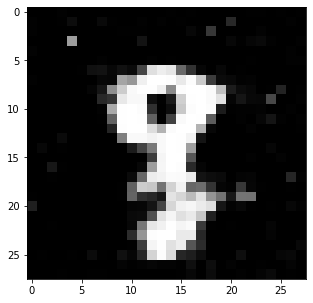

42001 [D loss: 0.571522, acc.: 73.44%] [G loss: 1.256769]
42002 [D loss: 0.562922, acc.: 68.75%] [G loss: 1.212768]
42003 [D loss: 0.528460, acc.: 75.00%] [G loss: 1.308121]
42004 [D loss: 0.608413, acc.: 64.06%] [G loss: 1.335389]
42005 [D loss: 0.678966, acc.: 62.50%] [G loss: 1.290364]
42006 [D loss: 0.693246, acc.: 56.25%] [G loss: 1.165324]
42007 [D loss: 0.628218, acc.: 59.38%] [G loss: 1.484932]
42008 [D loss: 0.626709, acc.: 64.06%] [G loss: 1.146544]
42009 [D loss: 0.576426, acc.: 68.75%] [G loss: 1.253371]
42010 [D loss: 0.637539, acc.: 59.38%] [G loss: 1.335205]
42011 [D loss: 0.593849, acc.: 67.19%] [G loss: 1.567333]
42012 [D loss: 0.598883, acc.: 64.06%] [G loss: 1.176972]
42013 [D loss: 0.629238, acc.: 65.62%] [G loss: 1.187096]
42014 [D loss: 0.679258, acc.: 56.25%] [G loss: 1.198256]
42015 [D loss: 0.572021, acc.: 60.94%] [G loss: 1.373830]
42016 [D loss: 0.541461, acc.: 75.00%] [G loss: 1.190883]
42017 [D loss: 0.672238, acc.: 54.69%] [G loss: 1.259951]
42018 [D loss:

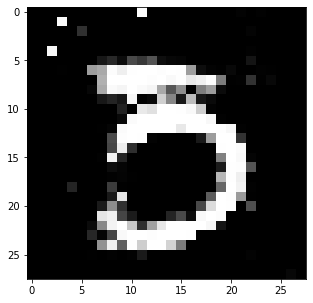

43001 [D loss: 0.648520, acc.: 64.06%] [G loss: 1.212106]
43002 [D loss: 0.566689, acc.: 70.31%] [G loss: 1.227944]
43003 [D loss: 0.645873, acc.: 65.62%] [G loss: 1.193466]
43004 [D loss: 0.574640, acc.: 75.00%] [G loss: 1.317144]
43005 [D loss: 0.657332, acc.: 68.75%] [G loss: 1.384260]
43006 [D loss: 0.629166, acc.: 68.75%] [G loss: 1.365610]
43007 [D loss: 0.655202, acc.: 57.81%] [G loss: 1.257280]
43008 [D loss: 0.662935, acc.: 57.81%] [G loss: 1.265689]
43009 [D loss: 0.607675, acc.: 59.38%] [G loss: 1.164892]
43010 [D loss: 0.498739, acc.: 78.12%] [G loss: 1.193583]
43011 [D loss: 0.616286, acc.: 65.62%] [G loss: 1.247871]
43012 [D loss: 0.622515, acc.: 62.50%] [G loss: 1.330540]
43013 [D loss: 0.735489, acc.: 43.75%] [G loss: 1.191544]
43014 [D loss: 0.561424, acc.: 68.75%] [G loss: 1.373142]
43015 [D loss: 0.715186, acc.: 60.94%] [G loss: 1.052288]
43016 [D loss: 0.661278, acc.: 57.81%] [G loss: 1.209867]
43017 [D loss: 0.576790, acc.: 64.06%] [G loss: 1.290461]
43018 [D loss:

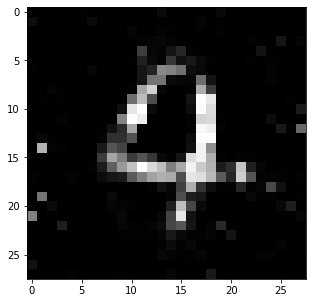

44001 [D loss: 0.469183, acc.: 79.69%] [G loss: 1.225628]
44002 [D loss: 0.627992, acc.: 60.94%] [G loss: 1.361537]
44003 [D loss: 0.659415, acc.: 62.50%] [G loss: 1.211198]
44004 [D loss: 0.595729, acc.: 65.62%] [G loss: 1.134923]
44005 [D loss: 0.632949, acc.: 60.94%] [G loss: 1.362975]
44006 [D loss: 0.622550, acc.: 59.38%] [G loss: 1.353932]
44007 [D loss: 0.644483, acc.: 70.31%] [G loss: 1.286529]
44008 [D loss: 0.591062, acc.: 62.50%] [G loss: 1.153734]
44009 [D loss: 0.616793, acc.: 64.06%] [G loss: 1.287992]
44010 [D loss: 0.611681, acc.: 67.19%] [G loss: 1.212644]
44011 [D loss: 0.571738, acc.: 65.62%] [G loss: 1.347481]
44012 [D loss: 0.638069, acc.: 65.62%] [G loss: 1.365434]
44013 [D loss: 0.566219, acc.: 71.88%] [G loss: 1.219693]
44014 [D loss: 0.598622, acc.: 67.19%] [G loss: 1.157278]
44015 [D loss: 0.547825, acc.: 73.44%] [G loss: 1.228693]
44016 [D loss: 0.545282, acc.: 71.88%] [G loss: 1.295928]
44017 [D loss: 0.573699, acc.: 62.50%] [G loss: 1.393751]
44018 [D loss:

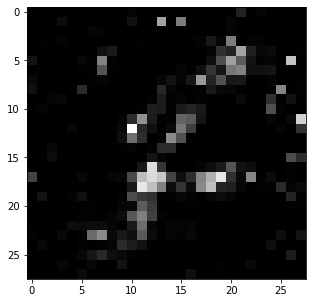

45001 [D loss: 0.571825, acc.: 67.19%] [G loss: 1.214234]
45002 [D loss: 0.641998, acc.: 65.62%] [G loss: 1.343027]
45003 [D loss: 0.632246, acc.: 64.06%] [G loss: 1.296796]
45004 [D loss: 0.692752, acc.: 59.38%] [G loss: 1.246582]
45005 [D loss: 0.629019, acc.: 62.50%] [G loss: 1.322896]
45006 [D loss: 0.567077, acc.: 62.50%] [G loss: 1.187255]
45007 [D loss: 0.652973, acc.: 62.50%] [G loss: 1.260209]
45008 [D loss: 0.640577, acc.: 68.75%] [G loss: 1.234746]
45009 [D loss: 0.515097, acc.: 73.44%] [G loss: 1.342661]
45010 [D loss: 0.659666, acc.: 62.50%] [G loss: 1.131889]
45011 [D loss: 0.579853, acc.: 65.62%] [G loss: 1.385318]
45012 [D loss: 0.594360, acc.: 68.75%] [G loss: 1.284215]
45013 [D loss: 0.603213, acc.: 68.75%] [G loss: 1.326925]
45014 [D loss: 0.599460, acc.: 68.75%] [G loss: 1.416388]
45015 [D loss: 0.607100, acc.: 67.19%] [G loss: 1.222849]
45016 [D loss: 0.575113, acc.: 70.31%] [G loss: 1.386645]
45017 [D loss: 0.552688, acc.: 68.75%] [G loss: 1.242280]
45018 [D loss:

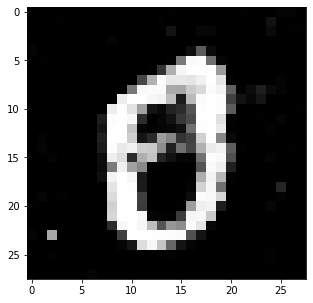

46001 [D loss: 0.619124, acc.: 60.94%] [G loss: 1.124050]
46002 [D loss: 0.609328, acc.: 64.06%] [G loss: 1.421462]
46003 [D loss: 0.468508, acc.: 84.38%] [G loss: 1.414582]
46004 [D loss: 0.561705, acc.: 65.62%] [G loss: 1.353856]
46005 [D loss: 0.615405, acc.: 60.94%] [G loss: 1.257497]
46006 [D loss: 0.526349, acc.: 68.75%] [G loss: 1.442885]
46007 [D loss: 0.654642, acc.: 62.50%] [G loss: 1.163691]
46008 [D loss: 0.581539, acc.: 68.75%] [G loss: 1.256176]
46009 [D loss: 0.613651, acc.: 64.06%] [G loss: 1.232841]
46010 [D loss: 0.586167, acc.: 78.12%] [G loss: 1.372328]
46011 [D loss: 0.530359, acc.: 75.00%] [G loss: 1.310863]
46012 [D loss: 0.589655, acc.: 59.38%] [G loss: 1.518809]
46013 [D loss: 0.671628, acc.: 67.19%] [G loss: 1.146869]
46014 [D loss: 0.631602, acc.: 64.06%] [G loss: 1.126874]
46015 [D loss: 0.634185, acc.: 60.94%] [G loss: 1.291671]
46016 [D loss: 0.501591, acc.: 76.56%] [G loss: 1.292104]
46017 [D loss: 0.556610, acc.: 71.88%] [G loss: 1.304991]
46018 [D loss:

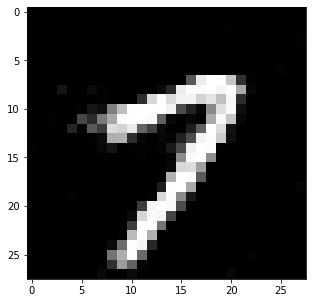

47001 [D loss: 0.640187, acc.: 62.50%] [G loss: 1.302256]
47002 [D loss: 0.659524, acc.: 54.69%] [G loss: 1.170972]
47003 [D loss: 0.590081, acc.: 64.06%] [G loss: 1.344807]
47004 [D loss: 0.625203, acc.: 56.25%] [G loss: 1.209897]
47005 [D loss: 0.592268, acc.: 73.44%] [G loss: 1.333412]
47006 [D loss: 0.691334, acc.: 59.38%] [G loss: 1.198426]
47007 [D loss: 0.573934, acc.: 68.75%] [G loss: 1.174569]
47008 [D loss: 0.648132, acc.: 65.62%] [G loss: 1.377341]
47009 [D loss: 0.652979, acc.: 60.94%] [G loss: 1.350200]
47010 [D loss: 0.563491, acc.: 70.31%] [G loss: 1.297619]
47011 [D loss: 0.564804, acc.: 73.44%] [G loss: 1.189886]
47012 [D loss: 0.604557, acc.: 70.31%] [G loss: 1.226651]
47013 [D loss: 0.648987, acc.: 59.38%] [G loss: 1.394876]
47014 [D loss: 0.655504, acc.: 59.38%] [G loss: 1.149642]
47015 [D loss: 0.541829, acc.: 73.44%] [G loss: 1.147771]
47016 [D loss: 0.528574, acc.: 75.00%] [G loss: 1.308329]
47017 [D loss: 0.659440, acc.: 59.38%] [G loss: 1.149405]
47018 [D loss:

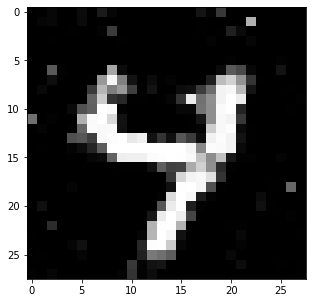

48001 [D loss: 0.557243, acc.: 79.69%] [G loss: 1.278486]
48002 [D loss: 0.488028, acc.: 76.56%] [G loss: 1.341024]
48003 [D loss: 0.524175, acc.: 73.44%] [G loss: 1.280508]
48004 [D loss: 0.773067, acc.: 56.25%] [G loss: 1.255782]
48005 [D loss: 0.505732, acc.: 78.12%] [G loss: 1.339365]
48006 [D loss: 0.561695, acc.: 70.31%] [G loss: 1.279209]
48007 [D loss: 0.538638, acc.: 68.75%] [G loss: 1.088482]
48008 [D loss: 0.688595, acc.: 59.38%] [G loss: 1.266412]
48009 [D loss: 0.573317, acc.: 70.31%] [G loss: 1.180143]
48010 [D loss: 0.658409, acc.: 62.50%] [G loss: 1.162536]
48011 [D loss: 0.700478, acc.: 67.19%] [G loss: 1.038337]
48012 [D loss: 0.696008, acc.: 54.69%] [G loss: 1.178083]
48013 [D loss: 0.603441, acc.: 68.75%] [G loss: 1.322057]
48014 [D loss: 0.601014, acc.: 65.62%] [G loss: 1.312264]
48015 [D loss: 0.578523, acc.: 67.19%] [G loss: 1.549541]
48016 [D loss: 0.559379, acc.: 67.19%] [G loss: 1.203735]
48017 [D loss: 0.594551, acc.: 67.19%] [G loss: 1.273810]
48018 [D loss:

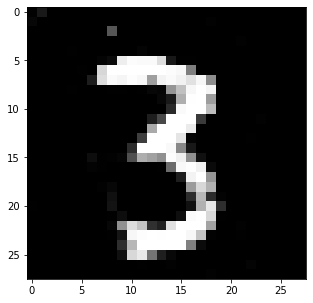

49001 [D loss: 0.574088, acc.: 68.75%] [G loss: 1.112794]
49002 [D loss: 0.668524, acc.: 57.81%] [G loss: 1.146948]
49003 [D loss: 0.587454, acc.: 68.75%] [G loss: 1.317030]
49004 [D loss: 0.495006, acc.: 79.69%] [G loss: 1.254440]
49005 [D loss: 0.551611, acc.: 71.88%] [G loss: 1.218390]
49006 [D loss: 0.627627, acc.: 59.38%] [G loss: 1.101541]
49007 [D loss: 0.646369, acc.: 59.38%] [G loss: 1.121543]
49008 [D loss: 0.585214, acc.: 68.75%] [G loss: 1.294986]
49009 [D loss: 0.638948, acc.: 65.62%] [G loss: 1.356714]
49010 [D loss: 0.625761, acc.: 64.06%] [G loss: 1.192320]
49011 [D loss: 0.615571, acc.: 70.31%] [G loss: 1.171223]
49012 [D loss: 0.591364, acc.: 73.44%] [G loss: 1.359043]
49013 [D loss: 0.711322, acc.: 54.69%] [G loss: 1.311241]
49014 [D loss: 0.597153, acc.: 57.81%] [G loss: 1.229228]
49015 [D loss: 0.607148, acc.: 62.50%] [G loss: 1.221726]
49016 [D loss: 0.629018, acc.: 60.94%] [G loss: 1.079203]
49017 [D loss: 0.610887, acc.: 64.06%] [G loss: 1.015813]
49018 [D loss:

In [11]:
gan = MNISTGAN()
gan.train(epochs=50000, batch_size=32, sample_interval=1000)